In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import paired_euclidean_distances
from scipy.spatial import distance  # Calculate distance between points

import nltk
import string

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

### Load the .csv file with all the data to be clustred

In [2]:
df = pd.read_csv('corpus.csv', nrows=1000)
df.head()

,file_id,text
0,9400,03 LiDCO Annual Report 200809 Technical Innova...
1,8174,Insp Ired Gam In GG roup p LC annua L report ...
2,6855,GREENE KING PLC Annual report 2013 site REVIEW...
3,8388,Invensys plc Annual Report and Accounts 200...
4,10924,NAUTICAL PETROLEUM PLC REPORT AND ACCOUNTS 200...


#### Take just the text column and lower all the text

In [3]:
data = df['text'].str.lower()
data

0      03 lidco annual report 200809 technical innova...
1      insp ired  gam in gg roup p lc annua l report ...
2      greene king plc annual report 2013 site review...
3      invensys plc    annual report and accounts 200...
4      nautical petroleum plc report and accounts 200...
                             ...                        
995    burberry group plc annual report 201112 chief ...
996    chief executive officers review 2012 has been ...
997    design and production by accrue the paper used...
998    strategic report 4 abcam plc annual report and...
999    .04   proof three  250315 what our customers a...
Name: text, Length: 1000, dtype: object

In [4]:
print(data.isna().sum())  # Shows how many empty rows exists
data = data.dropna()  # Drops the row that are empty
print(data.isna().sum())  # Shows how many empty rows exists after dropna

1
0


In [5]:
tf_idf_vectorizor = TfidfVectorizer(stop_words = 'english',#tokenizer = tokenize_and_stem,
                             max_features = 20000)
tf_idf = tf_idf_vectorizor.fit_transform(data)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

#### Feature names

In [6]:
pd.DataFrame(tf_idf_array, columns=tf_idf_vectorizor.get_feature_names()).head()

,00,000,00000hillandsmitharbck,0001,000s,001,0011,0025,004,005,...,zircadian,zloty,zn,zoladex,zone,zones,zoo,zoopla,zurich,zygos
0,0.000000,0.150376,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
1,0.004371,0.069226,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
2,0.000000,0.006357,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.002403
3,0.005720,0.000000,0.0,0.0,0.00175,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.001083,0.0,0.0,0.0,0.0,0.000000
4,0.000982,0.081162,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000


## PCA

In [7]:
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)

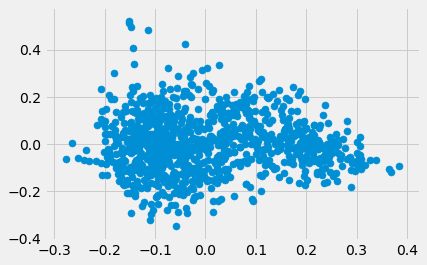

In [8]:
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], s=50, cmap='viridis')

## K- Means

In [9]:
estimater = KMeans(n_clusters = 3)
estimater.fit(Y_sklearn)
predicted_values = estimater.predict(Y_sklearn)

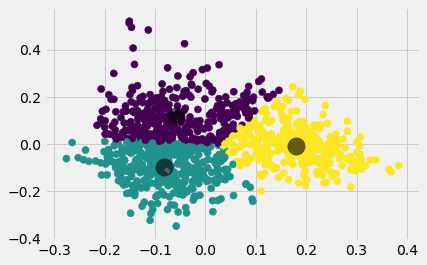

In [10]:
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=50, cmap='viridis')

centers = estimater.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

#### Cluster centers

In [11]:
print(estimater.cluster_centers_)

[[-0.0578396   0.11769358]
 [-0.08138729 -0.09815895]
 [ 0.17904169 -0.00608077]]


## Calculate distance between centroids

In [12]:
centroid_distance = distance.cdist(estimater.cluster_centers_, estimater.cluster_centers_, 'euclidean')

In [13]:
print(centroid_distance)

[[0.         0.21713316 0.26726923]
 [0.21713316 0.         0.27622752]
 [0.26726923 0.27622752 0.        ]]


## M1 - Average distance between centroids

In [14]:
M1 = np.mean(np.unique(centroid_distance[np.nonzero(centroid_distance)]))
print(f'M1 - Average distance between cnetroids: {M1}')

M1 - Average distance between cnetroids: 0.25354330193333213


In [15]:
min_distance_cluster = np.min(centroid_distance[np.nonzero(centroid_distance)])  # Find minimum value in centroid distance
print(f'Minimum distance between centroids: {min_distance_cluster}')

Minimum distance between centroids: 0.2171331584331671


### Davied Bouldin Score

Lower -> Better

In [16]:
davies_bouldin_score(Y_sklearn, predicted_values)

0.8566083142648703

### Silhouette score

Higher -> Better

In [17]:
silhouette_score(Y_sklearn, predicted_values)

0.40503121260014535

### Dunn Index

In [18]:
results = predicted_values.reshape(predicted_values.shape[0], 1)
results = np.concatenate((Y_sklearn, results), axis=1)

Total results

In [19]:
display(results)
results.shape

array([[-0.10148887, -0.05305169,  1.        ],
       [-0.14089274,  0.33727976,  0.        ],
       [ 0.11591307, -0.02086373,  2.        ],
       ...,
       [-0.11915847,  0.12099617,  0.        ],
       [ 0.21055539,  0.00310332,  2.        ],
       [ 0.14005343,  0.00738713,  2.        ]])

(999, 3)

#### Cluster 0 max distance

In [20]:
cluster0 = results[np.where(results[:, 2] == 0)][:, [0,1]]
cluster0_X = cluster0[:, 0].reshape(cluster0[:, 0].shape[0], 1)
cluster0_Y = cluster0[:, 1].reshape(cluster0[:, 1].shape[0], 1)
cluster0_distance = paired_euclidean_distances(cluster0_X, cluster0_Y)
cluster0_max_distance = np.max(cluster0_distance)
print(f'Cluster 0 max distance: {cluster0_max_distance}')

Cluster 0 max distance: 0.6709954448403186


#### Cluster 1 max distance

In [21]:
cluster1 = results[np.where(results[:, 2] == 1)][:, [0,1]]
cluster1_X = cluster1[:, 0].reshape(cluster1[:, 0].shape[0], 1)
cluster1_Y = cluster1[:, 1].reshape(cluster1[:, 1].shape[0], 1)
cluster1_distance = paired_euclidean_distances(cluster1_X, cluster1_Y)
cluster1_max_distance = np.max(cluster1_distance)
print(f'Cluster 1 max distance: {cluster1_max_distance}')

Cluster 1 max distance: 0.33599385415932037


#### Cluster 2 max distance

In [22]:
cluster2 = results[np.where(results[:, 2] == 2)][:, [0,1]]
cluster2_X = cluster2[:, 0].reshape(cluster2[:, 0].shape[0], 1)
cluster2_Y = cluster2[:, 1].reshape(cluster2[:, 1].shape[0], 1)
cluster2_distance = paired_euclidean_distances(cluster2_X, cluster2_Y)
cluster2_max_distance = np.max(cluster2_distance)
print(f'Cluster 1 max distance: {cluster2_max_distance}')

Cluster 1 max distance: 0.4852669570678094


In [23]:
max_distance = max(cluster0_max_distance, cluster1_max_distance, cluster2_max_distance)
print(f'Max distance in cluster: {max_distance}')
print(f'Min distance between centroids: {min_distance_cluster}')
dunn_index_value = min_distance_cluster / max_distance
print(f'Dunn index value: {dunn_index_value}')

Max distance in cluster: 0.6709954448403186
Min distance between centroids: 0.2171331584331671
Dunn index value: 0.3235985580868433


## Avg distance to centroid
### Transform the predicted values to values as distance to center of the centroid

In [24]:
res = estimater.transform(Y_sklearn)
print(res)

[[0.17623622 0.04938359 0.28443569]
 [0.23476779 0.4394858  0.4693128 ]
 [0.22223438 0.21190088 0.0648364 ]
 ...
 [0.06140774 0.22238622 0.32414794]
 [0.29183351 0.30900578 0.0328247 ]
 [0.22655941 0.2453079  0.04124886]]


## M2 Intra cluster distance for each cluster:
### Average distance to centroid

In [25]:
# Add cluster classificaiton to the array for filtering
pred_vals = predicted_values.reshape(predicted_values.shape[0], 1)
res_cluster = np.concatenate((res, pred_vals), axis=1)
print(res_cluster)

[[0.17623622 0.04938359 0.28443569 1.        ]
 [0.23476779 0.4394858  0.4693128  0.        ]
 [0.22223438 0.21190088 0.0648364  2.        ]
 ...
 [0.06140774 0.22238622 0.32414794 0.        ]
 [0.29183351 0.30900578 0.0328247  2.        ]
 [0.22655941 0.2453079  0.04124886 2.        ]]


In [26]:
# Extract distance to centroid for each cluster
dist_cluster0 = res_cluster[np.where(res_cluster[:, 3] == 0)][:,0]
dist_cluster1 = res_cluster[np.where(res_cluster[:, 3] == 1)][:,1]
dist_cluster2 = res_cluster[np.where(res_cluster[:, 3] == 2)][:,2]

In [27]:
# Calc average distance to centroid for each cluster
avg_dist_cluster0 = np.mean(dist_cluster0)
avg_dist_cluster1 = np.mean(dist_cluster1)
avg_dist_cluster2 = np.mean(dist_cluster2)

In [28]:
# Total average of distance to centroid
M2_total_avg_dist = np.mean([(avg_dist_cluster0, avg_dist_cluster1, avg_dist_cluster2)])

In [29]:
# Print values
print(f'Cluster 0 Avg distance to centroid: {avg_dist_cluster0}')
print(f'Cluster 1 Avg distance to centroid: {avg_dist_cluster1}')
print(f'Cluster 1 Avg distance to centroid: {avg_dist_cluster2}')
print(f'[M2] Total average distance to centroid: {M2_total_avg_dist}')

Cluster 0 Avg distance to centroid: 0.10640674435403999
Cluster 1 Avg distance to centroid: 0.09045871098789303
Cluster 1 Avg distance to centroid: 0.09578496224127567
[M2] Total average distance to centroid: 0.09755013919440288


## M3 - Maximum Radius

In [30]:
cluster0_max_radius = np.max(dist_cluster0)
cluster1_max_radius = np.max(dist_cluster1)
cluster2_max_radius = np.max(dist_cluster2)
M3_maximum_radius = np.max([(cluster0_max_radius, cluster1_max_radius, cluster2_max_radius)])
print(f'Cluster 0 Max Radius: {cluster0_max_radius}')
print(f'Cluster 1 Max Radius: {cluster1_max_radius}')
print(f'Cluster 2 Max Radius: {cluster2_max_radius}')
print(f'[M3] Maximum Radius: {M3_maximum_radius}')

Cluster 0 Max Radius: 0.4129392873040992
Cluster 1 Max Radius: 0.24955899951276664
Cluster 2 Max Radius: 0.2481628389403187
[M3] Maximum Radius: 0.4129392873040992


## M4 - Average Radius

In [31]:
M4_avg_radius = np.mean([(cluster0_max_radius, cluster1_max_radius, cluster2_max_radius)])
print(f'[M4] Average Radius: {M4_avg_radius}')

[M4] Average Radius: 0.3035537085857282


Each column is values of distances to each centroid

In [32]:
print(f'Shape: {res.shape}')

Shape: (999, 3)


Calculate the avg distance in each row of the np array

In [33]:
avg_distance = np.mean(res, axis=0)  # axis=1 rows ; axis=0 columns
print('Avg distance to centroid:')
print(f'Cluster 1: {avg_distance[0]}')
print(f'Cluster 2: {avg_distance[1]}')
print(f'Cluster 3: {avg_distance[2]}')

Avg distance to centroid:
Cluster 1: 0.20126344773399946
Cluster 2: 0.19332773755854069
Cluster 3: 0.2311019513094972


In [34]:
avg_distance

array([0.20126345, 0.19332774, 0.23110195])

## Purity

$Purity = \frac 1 N \sum_{i=1}^k max_j | c_i \cap t_j |$
- N - Number of nodes
- K - Number of clusters (in our case K = 3)
- C - Ground truth clusters
- t - Results classification

### Creating ground truth

backup variables

In [35]:
t_predicted_values = predicted_values
ground_truth = Y_sklearn

reshaping for concat

In [36]:
t_predicted_values.shape

t = t_predicted_values.reshape(ground_truth.shape[0], 1)

print(f'Predicted values shape: {t.shape}')

print(f'Y_sklearn shape: {ground_truth.shape}')

Predicted values shape: (999, 1)
Y_sklearn shape: (999, 2)


### Concat the arrays
#### Now we have ground truth classficaiton of the data : (axis, axis, cluster)

In [37]:
ground_truth = np.concatenate((ground_truth, t), axis=1)

In [38]:
pd.DataFrame(ground_truth, columns=['axis1', 'axis2', 'cluster']).head()

,axis1,axis2,cluster
0,-0.101489,-0.053052,1.0
1,-0.140893,0.337280,0.0
2,0.115913,-0.020864,2.0
3,-0.039021,-0.109507,1.0
4,-0.114969,0.148440,0.0


In [39]:
ground_truth[:,2]

x, y = np.unique(ground_truth[:,2], return_counts=True)

x = [int(v) for v in x.tolist()]
total = np.sum(y)
y = [int(v) for v in y.tolist()]
x_y = dict(zip(x, y))
print(f'Total: {total}')

Total: 999


{0: 334, 1: 383, 2: 282}


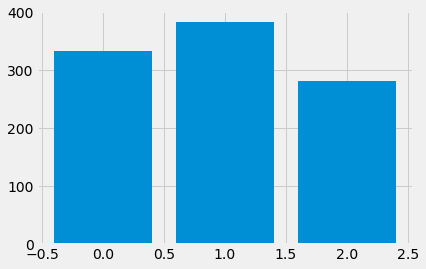

In [40]:
plt.bar(x, y)
print(x_y)

In [41]:
def create_confusion_matrix(truth):
    con_matrix = {0: list(), 1: list(), 2: list()}
    values = list(map(int, truth[:,2]))
    for index in range(len(values)):
        con_matrix[values[index]].append(index)
    return con_matrix

In [42]:
create_confusion_matrix(ground_truth)

{0: [1,
  4,
  6,
  7,
  14,
  15,
  16,
  17,
  19,
  20,
  29,
  39,
  41,
  44,
  45,
  49,
  50,
  52,
  53,
  54,
  55,
  58,
  61,
  62,
  64,
  67,
  68,
  69,
  72,
  74,
  75,
  77,
  79,
  81,
  85,
  86,
  89,
  92,
  98,
  102,
  104,
  105,
  106,
  107,
  108,
  110,
  113,
  116,
  118,
  121,
  123,
  124,
  127,
  128,
  131,
  134,
  135,
  137,
  141,
  142,
  143,
  144,
  145,
  149,
  151,
  155,
  156,
  157,
  161,
  163,
  164,
  168,
  170,
  181,
  182,
  183,
  185,
  186,
  188,
  193,
  201,
  202,
  204,
  206,
  208,
  209,
  210,
  211,
  220,
  222,
  230,
  231,
  233,
  234,
  240,
  243,
  245,
  249,
  254,
  256,
  258,
  261,
  262,
  268,
  269,
  270,
  274,
  275,
  281,
  283,
  284,
  285,
  286,
  290,
  291,
  293,
  297,
  299,
  300,
  305,
  310,
  313,
  315,
  316,
  317,
  329,
  330,
  338,
  342,
  343,
  347,
  353,
  354,
  356,
  358,
  360,
  362,
  363,
  374,
  377,
  387,
  389,
  393,
  401,
  412,
  423,
  425,
  427,
  43